In [157]:
# all needed libraries are imported here
import re
import sys
import requests as requests
import pandas as pd
import matplotlib.pyplot as plt
import wikipedia as wiki
import numpy as np
from statsmodels.stats import diagnostic
import wikipediaapi
import os
import pandas as pd
import sys
import spacy

# 1. Data scraping

We use the REST API from http://petermeissner.de:8880/ in order to extract pageviews for the articles,
from January 2012 up until december 2015.
We do this for both English and German Wikipedia.

In [109]:
# Helper function, extracts pageviews for a list of articles and a given language and specified years
# and returns a dataframe with the associated information

def get_pageview_data(articles, years, lang, save_csv=True):
    
    # initialize the search url
    search_url = f'http://petermeissner.de:8880/article/exact/{lang}/'
    final_list = []
    
    for article in articles:
        
        # small technical detail, we have to transofrm spaces in the page names into underscores.
        article_no_spaces = re.sub(r'\s','_', article)
        request = requests.get(search_url + article_no_spaces).json()
        
        # verify everything went well
        if request['status'] != 'ok':
            print(f'Problem fetching data for article {article}')
            continue
            
        data = request['data']
        for elem in data:
            year = elem['year']
            if str(year) in years:
                # create a date_range for the specific year
                timestamps = pd.date_range(f'01-01-{year}', f'31-12-{year}')
                page_views = elem['page_view_count'].split(',')
                # quick sanity check
                assert len(timestamps) == len(page_views)
                final_list += list(zip(timestamps, [article] * len(timestamps), [lang] * len(timestamps), page_views))
    
    # create the needed dataframe and save it if specified
    df = pd.DataFrame(final_list, columns=['date', 'article','language', 'pageviews'])
    if save_csv:
        df.to_csv(f'data/data_{lang}.csv')
    return df
    

In [110]:
# Declare the desired article names for English and German

terrorism_articles_en = ['abu_sayyaf', 'afghanistan', 'agro', 'al-qaeda',
                      'al-qaeda_in_the_arabian_peninsula',
                      'al-qaeda_in_the_islamic_maghreb', 'al-shabaab',
                      'ammonium_nitrate', 'attack', 'biological_weapon', 'car_bomb',
                      'chemical_weapon', 'conventional_weapon', 'dirty_bomb',
                      'eco-terrorism', 'environmental_terrorism',
                      'euskadi_ta_askatasuna', 'extremism', 'farc', 'fundamentalism',
                      'hamas', 'hezbollah', 'improvised_explosive_device', 'iran',
                      'iraq', 'irish_republican_army', 'islamist', 'jihad',
                      'nationalism', 'nigeria', 'nuclear', 'nuclear_enrichment',
                      'pakistan', 'palestine_liberation_front', 'pirates', 'plo',
                      'political_radicalism', 'recruitment', 'somalia', 'suicide_attack',
                      'suicide_bomber', 'taliban', 'tamil_tigers',
                      'tehrik-i-taliban_pakistan', 'terror', 'terrorism',
                      'weapons-grade', 'yemen']

terrorism_articles_de = ['al-Qaida','Terrorismus', 'Terror (Begriffsklärung)', 'Angriff', 'Irak', 'Afghanistan',
                        'Iran', 'Pakistan', 'Agroterrorismus', 'Ökoterrorismus','Hochangereichertes Uran',"Chemische Waffe", "Ammoniumnitrat",
                        "Unkonventionelle Spreng- und Brandvorrichtung", "Abu Sajaf", "Hamas",
                        "FARC-EP", "Geschichte der Irisch-Republikanischen Armee", "Euskadi Ta Askatasuna" , "Hisbollah",
                        "Liberation Tigers of Tamil Eelam", "Palästinensische Befreiungsorganisation", "Palästinensische Befreiungsfront", 
                        "Autobombe", "Dschihad", "Taliban",
                        'Islamismus', 'Fundamentalismus', 'Personalbeschaffung', 'Nationalismus', 'Al-Shabaab',
                        'Radikalismus', 'Nigeria', 'Somalia', 'Extremismus', 'Piraterie', 'Jemen', 'Tehrik-i-Taliban Pakistan',
                        'Al-Qaida im Maghreb', 'Al-Qaida auf der Arabischen Halbinsel', 'Selbstmordattentat']

years = ['2012','2013','2014','2015']

In [111]:
# small convenience variable so that we don't have to re_use the api each time
use_api = False

if use_api:
    data_en = get_pageview_data(terrorism_articles_en, years, 'en', save_csv=True)
    data_de = get_pageview_data(terrorism_articles_de, years, 'de', save_csv=True)
else:
    data_en = pd.read_csv('data/data_en.csv', parse_dates=['date'], index_col=0)
    data_de = pd.read_csv('data/data_de.csv', parse_dates=['date'], index_col=0)

data_en['pageviews'] = data_en['pageviews'].astype(int)

There is a problem fetching data for the german version of the irish republican army article, although it does exist on Wikipedia.

In [112]:
data_en.head()

,date,article,language,pageviews
0,2012-01-01,abu_sayyaf,en,254
1,2012-01-02,abu_sayyaf,en,351
2,2012-01-03,abu_sayyaf,en,423
3,2012-01-04,abu_sayyaf,en,418
4,2012-01-05,abu_sayyaf,en,804


In [113]:
data_de.head()

,date,article,language,pageviews
0,2012-01-01,al-Qaida,de,438
1,2012-01-02,al-Qaida,de,9
2,2012-01-03,al-Qaida,de,669
3,2012-01-04,al-Qaida,de,659
4,2012-01-05,al-Qaida,de,746


# 2. Verifications and Tests
We perform some sanity checks on the data, and find that some values may be missing. For the English articles, we compare the results with the data given to us for Milestone P2 replication.

## Checks

In [114]:
print(len(data_en.article.unique()))
print(len(terrorism_articles_en))
print(len(data_de.article.unique()))
print(len(terrorism_articles_de))

48
48
40
41


This is expected as we were not able to retrieve one of the German articles data

In [115]:
# load the pageviews given for the replication
reference = pd.read_csv('data/terrorism_data.csv')
testing_ref_data = reference.set_index(['date','article']).loc[:, 'views'].astype(int).sort_index(level=[0,1])

test_en = data_en.loc[data_en.date.isin(reference.date)].set_index(['date','article']).\
       sort_index(level=[0,1])['pageviews'].astype(int)

np.count_nonzero((test_en.values == testing_ref_data.values)) == len(test)

True

We have **exactly the same** pageviews as the ones given for the replication, which a good sign.

## Scatter plots of the data

In [136]:
grouped_en = data_en.groupby(pd.Grouper(key='date', freq='M'))['pageviews'].sum()

In [151]:
# fig, axs = plt.subplots(1,2)


In [107]:
# drop the language column
data_en = data_en.drop('language', axis=1)
data_de = data_de.drop('language', axis=1)

# filter all rows corresponding to the article about Hamas, as it represents an outlier in the data
data_en = data_en[data_en.article != 'hamas']
data_de = data_de[data_de.article != 'hamas']

# Q1: Is the Chilling effect found persistent?

In [146]:
# Helper function, performs all the necessary operations to prepare the data for ITS regression

def prepare_data_for_regression(data):
    pageviews_per_month = data.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
    # june 2013 and its index, where the months are counted from 1 to 32
    june_2013 = pd.to_datetime('2013-06-30')
    june_2013_index = 18 

    # prepare columns for the regression

    # intervention is an indicator function, which takes the value 1 for rows after June 2013
    pageviews_per_month['intervention'] = (pageviews_per_month.date >= june_2013).astype(int)

    # time is the sequence [1,2,..,32] as we have 32 months
    pageviews_per_month ['time'] = range(1,len(pageviews_per_month) + 1)

    # post_slope is 0 before June 2013, then 1,2,.. starting June 2013
    pageviews_per_month['post_slope'] = (pageviews_per_month['time'] - june_2013_index + 1) * \
                                         pageviews_per_month['intervention']
    
    return pageviews_per_month

# Q2: Is the Chilling effect only restrained to English Wikipedia?

## Data considered
difference here:  
why here:

In [182]:
terrorism_articles_en = ['Abu Sayyaf', 'afghanistan', 'Agro-terrorism', 'al-qaeda',
       'Al-Qaeda in the Arabian Peninsula',
       'Al-Qaeda in the Islamic Maghreb', 'al-shabaab',
       'ammonium_nitrate', 'Offensive (military)', 'biological_weapon', 'car_bomb',
       'chemical_weapon', 'conventional_weapon', 'dirty_bomb',
       'eco-terrorism', 'environmental_terrorism',
       'Euskadi ta Askatasuna', 'extremism', 'farc', 'fundamentalism',
       'hamas', 'hezbollah', 'improvised_explosive_device', 'iran',
       'iraq', 'Irish Republican Army', 'islamist', 'jihad',
       'nationalism', 'nigeria', 'Nuclear weapon', 'nuclear_enrichment',
       'pakistan', 'Palestine Liberation Front', 'pirates', 'PLO',
       'political_radicalism', 'recruitment', 'somalia', 'suicide_attack',
       'suicide_bomber', 'taliban', 'tamil_tigers',
       'Tehrik-i-Taliban Pakistan', 'Terror (politics)', 'terrorism',
       'weapons-grade', 'yemen']

categories_selected_de = ['Kategorie:Afghanistan', 'Kategorie:Afghanistankrieg (seit 1978)', 'Kategorie:Al-Qaida',
                       'Kategorie:Antisemitismus', 'Kategorie:Anti-Freimaurerei','Kategorie:Antizionismus',
                       'Kategorie:Asymmetrische Kriegführung', 'Kategorie:Attentat', 'Kategorie:Bewaffnete islamistische Organisation',
                       'Kategorie:Bewaffnete islamistische Organisation', 'Kategorie:Bewaffnete islamistische Untergrundorganisation',
                       'Kategorie:Bombe', 'Kategorie:Hamas', 'Kategorie:Hisbollah','Kategorie:Islamische Republik',
                        'Kategorie:Islamistischer Terrorismus','Kategorie:Terrorismus', 'Kategorie:Taliban']

In [169]:
if np.nan:
    print('a')

a


In [175]:
def get_page_summaries(pages, lang, look_for_other_lang=False, other_lang='de'):

    summaries = []
    wiki = wikipediaapi.Wikipedia(lang)
    
    for page in pages:
        try:
            page_en = wiki.page(page)
            if look_for_other_lang:
                page_other = page_en.langlinks.get(other_lang, None)
                page_other_title = page_other.title if page_other else None
                summaries.append({'article_en': page, 'summary_en': page_en.summary, 
                      f'article_{other_lang}': page_other_title})
            else:
                summaries.append({'article_en': page, 'summary_en': page_en.summary})

        except:
            print(f"problem fetching data for page: {page}", file=sys.stderr)
            continue
        
    return pd.DataFrame(summaries)

In [176]:
summaries_en = get_page_summaries(terrorism_articles_en, 'en', look_for_other_lang=True, other_lang='de')

In [161]:
summaries_en.head()

,article_en,summary_en,article_de
0,Abu Sayyaf,Abu Sayyaf ( (listen); Arabic: جماعة أبو سياف‎...,Abu Sajaf
1,afghanistan,"Afghanistan ( (listen), also pronounced /ævˈɡæ...",Afghanistan
2,Agro-terrorism,"Agroterrorism, also known as agriterrorism and...",Agroterrorismus
3,al-qaeda,"Al-Qaeda (; Arabic: القاعدة‎ al-Qāʿidah, IPA: ...",Al-Qaida
4,Al-Qaeda in the Arabian Peninsula,Al-Qaeda in the Arabian Peninsula (Arabic: تنظ...,Al-Qaida auf der Arabischen Halbinsel


In [179]:
summaries_en.to_csv('data/summaries_en.csv')

In [180]:
def get_members_of_category(cat, lang, level=0, max_level=1):
    wiki = wikipediaapi.Wikipedia(lang)
    category_page = wiki.page(cat)
    all_pages_in_cat = []
    for c in category_page.categorymembers.values(): 
        if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
            all_pages_in_cat.extend(get_members_of_category(c, lang, level+1, max_level))
        else: 
            all_pages_in_cat.append(c.title)
    
    return all_pages_in_cat

In [183]:
potential_pages = set(summaries_en['article_de'])
for category in categories_selected_de:
    potential_pages.update(get_members_of_category(category,'de', 0, 3))

In [185]:
data_en = get_pageview_data(terrorism_articles_en, ['2012', '2013','2014'], 'en', save_csv=False)

In [186]:
date_de = get_pageview_data(potential_pages, ['2012', '2013','2014'], 'de', save_csv=False)

Problem fetching data for article Terroranschlag in Sierra Leone am 8. November 1998
Problem fetching data for article New Order (Organisation)
Problem fetching data for article Ar-Rahman-Legion
Problem fetching data for article Goyim Partei Deutschland
Problem fetching data for article Robin de Ruiter
Problem fetching data for article Antisemitismus in Belgien
Problem fetching data for article Beschädigung des Tagebuchs der Anne Frank
Problem fetching data for article Jamaat-ul-Ahrar
Problem fetching data for article Radau-Antisemitismus
Problem fetching data for article Operation Neptune Spear
Problem fetching data for article Werner Dittrich (Rassentheoretiker)
Problem fetching data for article Antiterrordateigesetz
Problem fetching data for article Operation Nördlicher Schutzschild


JSONDecodeError: Extra data: line 1 column 5 (char 4)

In [77]:
# Here we only keep the article pageviews for same period as the paper
data_en = data_en.loc[data_en.date <= '31-08-2014']
data_de = data_de.loc[data_de.date <= '31-08-2014']

In [138]:
def regression_groupby(df):
    
    reg_data = prepare_data_for_regression(df)
    model = smf.ols(formula='pageviews ~ time + C(intervention) + post_slope ', data=reg_data).fit()
    intervention = model.params[1]
    pre_slope = model.params[2]
    post_slope = model.params[3]
    pvalue_intervention = model.pvalues[1]
    pvalue_postslope = model.pvalues[3]
         
    return pd.DataFrame([[intervention, post_slope, pre_slope, pvalue_intervention, pvalue_postslope]],
                       columns=['intervention','post_slope','pre_slope','pvalue_intervention','pvalue_postslope'])

reg_per_article_en = data_en.groupby('article').apply(regression_groupby).reset_index(level=1, drop=True)
reg_per_article_de = data_de.groupby('article').apply(regression_groupby).reset_index(level=1, drop=True)


reg_per_article_en = reg_per_article_en.query(
    '(pvalue_intervention <= 0.05 and intervention < 0) and (pvalue_postslope <= 0.05 and (post_slope + pre_slope) < 0)')
reg_per_article_de = reg_per_article_de.query(
    '(pvalue_intervention <= 0.05 and intervention < 0) and (pvalue_postslope <= 0.05 and (post_slope + pre_slope) < 0)')

In [139]:
reg_per_article_en

,intervention,post_slope,pre_slope,pvalue_intervention,pvalue_postslope
article,,,,,
afghanistan,-86987.920557,-7455.049557,3964.465686,0.000133,2.537198e-04
al-qaeda,-94956.587476,-10165.021750,8532.404412,0.000681,8.200562e-05
al-qaeda_in_the_islamic_maghreb,-20192.596458,-2154.038860,2090.105392,0.000874,1.178847e-04
ammonium_nitrate,-36378.187603,-3229.552672,2670.894608,0.000137,1.667385e-04
car_bomb,-5336.202277,-427.919165,378.485294,0.000030,1.542157e-04
conventional_weapon,-1558.976977,-112.190006,104.600490,0.001092,7.753819e-03
dirty_bomb,-8925.789247,-512.415093,460.075980,0.000225,1.400187e-02
extremism,-6434.529538,-605.881989,528.541667,0.000258,1.487364e-04
fundamentalism,-13733.126755,-1118.235555,717.286765,0.000990,2.641822e-03


In [141]:
reg_per_article_de

,intervention,post_slope,pre_slope,pvalue_intervention,pvalue_postslope
article,,,,,
Hisbollah,-5951.677040,-580.932306,553.441176,0.020083,0.012271
Pakistan,-18623.795193,-724.393493,558.901961,0.000026,0.048550


## Comparison of English and German article pageviews

In [147]:
def get_page_summaries(pages, lang, look_for_other_lang=False, other_lang='de'):

    summaries = []
    wiki = wikipediaapi.Wikipedia(lang)
    
    for page in pages:
        try:
            page_en = wiki.page(page)
            if look_for_other_lang:
                page_other = page_en.langlinks.get(other_lang, None)
                page_other_title = page_other.title if page_other else None
                page_other_summary = page_other.summary if page_other else None
                summaries.append({'article_en': page, 'summary_en': page_en.summary, 
                          f'article_{other_lang}': page_other_title, f'summary_{other_lang}': page_other_summary})
            else:
                summaries.append({'article_en': page, 'summary_en': page_en.summary})

        except:
            print(f"problem fetching data for page: {page}", file=sys.stderr)
            continue
        
    return pd.DataFrame(summaries)

In [48]:
reg_data_en = prepare_data_for_regression(data_en)
reg_data_de = prepare_data_for_regression(data_de)

In [50]:
import statsmodels.formula.api as smf

model_en = smf.ols(formula='pageviews ~ time + C(intervention) + post_slope ', data=reg_data_en).fit()
model_de = smf.ols(formula='pageviews ~ time + C(intervention) + post_slope', data=reg_data_de).fit()

In [51]:
# We compute the predictions and 95% CIs for the two models
preds_en = model_en.get_prediction(reg_data_en)\
                .summary_frame(alpha=0.05)[['mean','mean_ci_lower', 'mean_ci_upper']]

preds_de = model_de.get_prediction(reg_data_de)\
                .summary_frame(alpha=0.05)[['mean','mean_ci_lower', 'mean_ci_upper']]

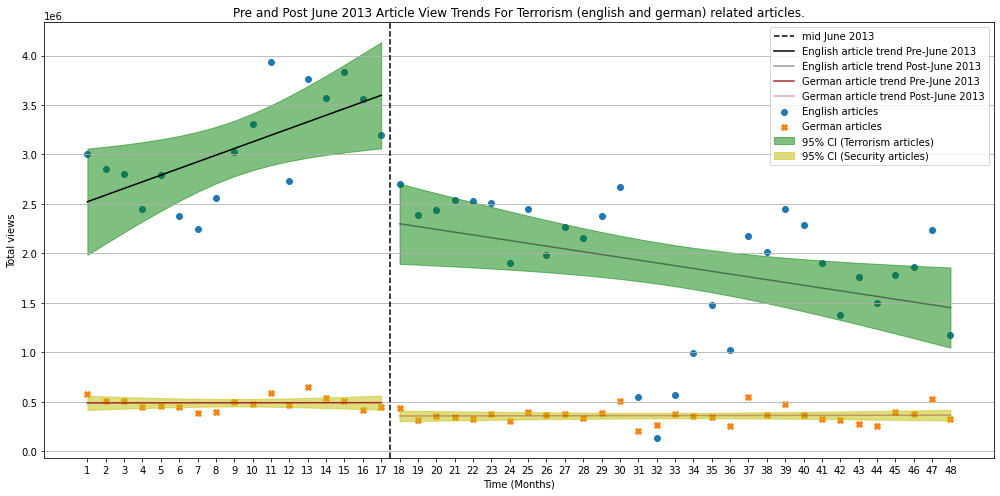

In [52]:
plt.figure(figsize=(14,7)) 

# some useful indexes (in the dataframe), ticks, etc
xticks = range(1, preds_en.shape[0] + 1)
start_index = 1
before_interruption_index = 17
after_interruption_index = 18
end_index = 48
# equivalent indexes in the dataframe
points_index = [start_index - 1, before_interruption_index - 1, after_interruption_index - 1, end_index - 1] 
# useful mask, when plotting CIs
ci_mask_before = np.array(xticks) <= before_interruption_index


# plot the article views
plt.scatter(data=reg_data_en, x='time', y='pageviews', label='English articles')
plt.scatter(data=reg_data_de ,x='time', y='pageviews', marker='X', label='German articles')

# Add ticks and a line representing the period just before the intervention
plt.xticks(xticks)
plt.axvline(x=after_interruption_index - 0.5, c='black', label='mid June 2013',ls='--')

# Terrorism lines
p1, p2, p3, p4 = preds_en.loc[points_index, 'mean']
plt.plot ([start_index, before_interruption_index], [p1, p2] , c='black', label= 'English article trend Pre-June 2013')
plt.plot ([after_interruption_index, end_index], [p3, p4] ,c='black', alpha=0.4, label= 'English article trend Post-June 2013')
plt.fill_between(x=xticks, y1=preds_en['mean_ci_lower'], y2=preds_en['mean_ci_upper'],color='g', where=ci_mask_before, alpha=0.5,\
                 label='95% CI (Terrorism articles)')
plt.fill_between(x=xticks, y1=preds_en['mean_ci_lower'], y2=preds_en['mean_ci_upper'],color='g', where=~ci_mask_before, alpha=0.5)

#domestic security lines
p1, p2, p3, p4 = preds_de.loc[points_index, 'mean']
plt.plot ([start_index, before_interruption_index], [p1, p2] , c='brown', label= 'German article trend Pre-June 2013')
plt.plot ([after_interruption_index, end_index], [p3, p4] ,c='brown', alpha=0.4, label= 'German article trend Post-June 2013')
plt.fill_between(x=xticks, y1=preds_de['mean_ci_lower'], y2=preds_de['mean_ci_upper'],color='y', where=ci_mask_before, alpha=0.5, \
                 label='95% CI (Security articles)')
plt.fill_between(x=xticks, y1=preds_de['mean_ci_lower'], y2=preds_de['mean_ci_upper'],color='y', where=~ci_mask_before, alpha=0.5)


# Add Title, labels and legend 
plt.title ("Pre and Post June 2013 Article View Trends For Terrorism (english and german) related articles.")
plt.xlabel("Time (Months)")
plt.ylabel("Total views")
plt.legend()

# Keep only the horizontal grid
plt.grid (False, axis='x')
plt.grid (True, axis='y')
plt.tight_layout()

plt.show()


In [152]:
reg_data.iloc[31]

date            2014-08-31 00:00:00
pageviews                    133212
intervention                      1
time                             32
post_slope                       15
Name: 31, dtype: object

In [168]:
diagnostic.kstest_normal(reg_data_de.loc[reg_data_de.intervention == 1,'pageviews'].values,'norm')

(0.1610107225076326, 0.04086892960493209)

In [53]:
model_de.summary() # 0.376, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     10.42
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           2.65e-05
Time:                        21:42:35   Log-Likelihood:                -605.95
No. Observations:                  48   AIC:                             1220.
Df Residuals:                      44   BIC:                             1227.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.883e+05   3.89e+04     12.539      0.000     4.1e+05    5.67e+05
C(intervention)[T.1] -1.348e+05   4.55e+04     -2.964      0.005   -2.27e+05   -4.32e+04
time                   140.5735   3800.661      0.037      0.971   -7519.155    7800.302
post_slope             122.5277   4101.398      0.030      0.976   -8143.296    8388.351
==============================================================================
Omnibus:                        3.645   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                2.752
Skew:                           0.571   Prob(JB):                        0.253
Kurtosis:                       3.268   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
model_en.params[1]


-1270472.029222014

In [57]:
model_en.params[3]


-95519.094710626

In [58]:
model_en.pvalues

Intercept               9.696717e-11
C(intervention)[T.1]    5.340730e-04
time                    2.233952e-02
post_slope              3.222562e-03
dtype: float64